# The Mountain Car Problem

In [1]:
# #@title Install dependencies

# #remove " > /dev/null 2>&1" to see what is going on under the hood
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# # !pip install gym[atari] > /dev/null 2>&1

In [2]:
#@title Wrapper function for openai gym rendering
import sys
import gym
import matplotlib
import matplotlib.pyplot as plt
import glob
import io
import base64

from gym import logger as gymlogger
from gym.wrappers import Monitor
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# %matplotlib inline
# gymlogger.set_level(40) #error only
# display = Display(visible=0, size=(1400, 900))
# display.start()

# """
# Utility functions to enable video recording of gym environment and displaying it
# To enable video, just do "env = wrap_env(env)""
# """

# # def show_video():
# #   mp4list = glob.glob('video/*.mp4')
# #   if len(mp4list) > 0:
# #     mp4 = mp4list[0]
# #     video = io.open(mp4, 'r+b').read()
# #     encoded = base64.b64encode(video)
# #     ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
# #                 loop controls style="height: 400px;">
# #                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
# #              </video>'''.format(encoded.decode('ascii'))))
# #   else: 
# #     print("Could not find video")
    

# # def wrap_env(env):
# #   env = Monitor(env, './video', force=True)
# #   return env

In [3]:
# !rm -rf ./video/*

# The mountain car problem

Consider the task of driving an underpowered car up a steep mountain road. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away the goal and up the opposite slope on the left. Then, by applying full throttle the car can build up enough inertia to carry it up the steep slope, even though it is slowing down the whole way. 

The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. 

At each time step, there are three possible actions:
1. Full throttle forward (+1)
2. Full throttle reverse (-1)
3. Zero throttle

The car moves according to a simplified physics. Its position, $x_t$, and velocity $\dot{x_t}$, are updated by
\begin{equation}
\begin{split}
x_{t+1} & = bound [x_{t} + \dot x_{t+1}]\\
\dot{x}_{t+1} & = bound[\dot{x}_t + 0.001A_t - 0.0025 \cos(3x_t)]
\end{split}
\end{equation}
where the $bound$ operation enforces $-1.2 \leq x_{t+1} \leq 0.5$ and $-0.07 \leq \dot{x}_{t+1} \leq 0.07$

Code reference:
https://github.com/udacity/deep-reinforcement-learning/blob/master/discretization/Discretization.ipynb

In [8]:
env = gym.make("MountainCar-v0")

In [9]:
print("Observation space: %s" % env.observation_space)
print("Action space: %s" % env.action_space)

Observation space: Box(2,)
Action space: Discrete(3)


In [10]:
GLOBAL_STEP = env.env.spec.max_episode_steps
SCORE_REQUIREMENT = -198
NUM_EPISODES = 10000

In [11]:
print(GLOBAL_STEP)

200


#### Play a random small game

In [ ]:
observation = env.reset()

In [ ]:
action = env.action_space.sample()

In [ ]:
env.step(action)

In [ ]:
observation = env.reset()

for i in range(GLOBAL_STEP):
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action) 
    
#     print("Observation: %s" % observation)
#     print("Reward: %s" % reward)
#     print("Done: %s" % done)
#     print("Info: %s" % info)
        
    if done: 
      break
            
env.close()
# show_video()

## Discretise the state space with a uniform grid

The mountain car moves in a continuous space. Before we can do the learning, we have to discretise the space. The way that we are discretising the space is by using a uniformly-spaced grid. 

First, we have to know what is the lower bounds and the upper bounds to decide the bins. 

### Approximation by Discretisation

In [12]:
print("State space: ", env.observation_space)
print("- low: ", env.observation_space.low)
print("- high: ", env.observation_space.high)

State space:  Box(2,)
- low:  [-1.2  -0.07]
- high:  [0.6  0.07]


The lower bounds and the upper bounds are represented by x,y coordinates. Thus, we can know the full grid would be with bottom-left coordinate [-1.2, -0.07] and top-right coordinate [0.6, 0.07]. Thus, we can split the grid uniformly, if using bins(10,10), to []

In [13]:
import numpy as np

In [14]:
def create_uniform_grid(low_bound, high_bound, bins=(10,10)):
    """
    Define a uniformly-spaced grid that can be used to discretise a space
    
    Args:
        low (array-like): Lower bounds
        high (array-like): Upper bounds
        bins (tuple)
    """
    
    assert len(low_bound) == len(high_bound) == len(bins)
    
    grid = [np.linspace(low_bound[d], high_bound[d], bins[d] + 1)[1:-1] for d in range(len(bins))]
    
    print("Uniform grid: [low, high] / bins => Splits")
    for l, h, b, splits in zip(low_bound, high_bound, bins, grid):
        print("\t [%s, %s] / %s => %s" % (l, h, b, splits))
    
    return grid

In [15]:
low = [-1.0, -5.0]
high = [1.0, 5.0]
grid = create_uniform_grid(low_bound=low, high_bound=high)

Uniform grid: [low, high] / bins => Splits
	 [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
	 [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]


In [16]:
def discretize(sample, grid):
    """
    Transform a x-y position to a discretised ID
    e.g.
    [-1.0 , -5.0] => [0, 0]
    
    Args:
        sample (array-like): 
            A single sample from the original continuous space
        grid (array-like):
            A list of arrays representing the grid
            
    Return:
        discretised_sample (array-like)
    """
    
    return list((np.digitize(s, g) for s, g in zip(sample, grid)))

In [17]:
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])

In [18]:
discretized_samples = np.array([discretize(s, grid) for s in samples])

In [19]:
discretized_samples

array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])

## Visualisation of the original sample space and the discretized sample space

In [20]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc

In [21]:
def visualise_samples(samples, discretized_samples, grid,
                      low=None, high=None):

    # Using the oop approach, create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)

    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # If not specify, use the last grid locations as low high
        low = [split[0] for splits in grid]
        high = [split[-1] for splits in grid]
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    # Plot the original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='red')

    # Plot the discretized samples
    ax.plot(locs[:, 0], locs[:, 1], 's', color='blue')

    # Add a line connecting each original-discretized sample
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))

    ax.legend(['original', 'discretized'])

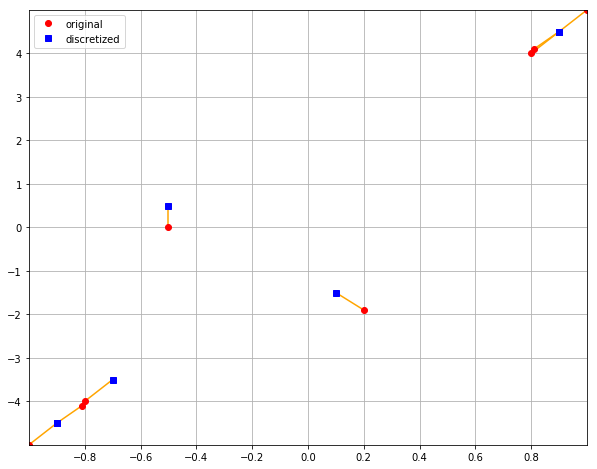

In [22]:
visualise_samples(samples, discretized_samples, grid,
                  low, high)

The methods are ready. Now, we can apply it to our reinforcement learning environment.

In [23]:
low = env.observation_space.low
high = env.observation_space.high

In [24]:
# Create uniform grid for the environment
grid = create_uniform_grid(low, high)

Uniform grid: [low, high] / bins => Splits
	 [-1.2, 0.6] / 10 => [-1.02000004 -0.84000003 -0.66000003 -0.48000002 -0.30000001 -0.12
  0.06        0.24000001  0.42000002]
	 [-0.07, 0.07] / 10 => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]


In [25]:
states_samples = np.array([env.observation_space.sample() for i in range(10)])

In [26]:
discretized_states_samples = np.array([discretize(s, grid) for s in states_samples])

In [27]:
discretize([0.4, -0.6], grid)

[array(8), array(0)]

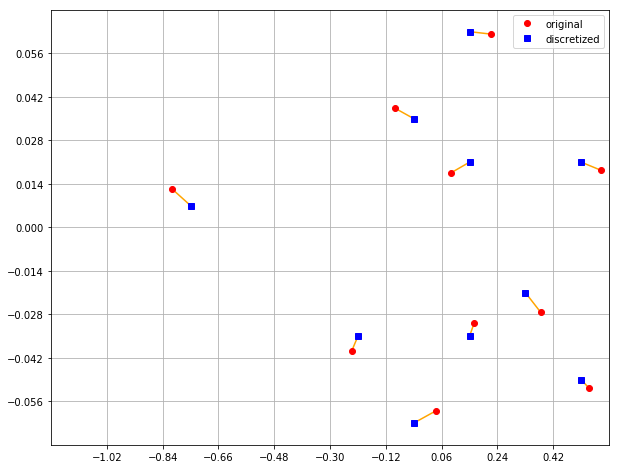

In [28]:
visualise_samples(states_samples, discretized_states_samples, grid,
                  low, high)

### 2. SARSA(0) Methods

### Pseudo code of SARSA
---
```
Initialise Q(s,a) for all s in S, a in A(s), arbitrarily, and Q(T,.)=0
Loop for each episode:
    Initialise S
    Choose A from S using policy derived from Q (e.g. esp-greedy)
    Loop for each step of episode:
        Take action A, observe R, S'
        Choose A' from S' using policy derived from Q (e.g. esp-greedy)
        Q(St,At) = Q(St,At) + alpha * (R + gamma * Q(St+1, At+1) - Q(St, At))
        St = St+1; At = At+1
        Until S is terminal
```
---

### How SARSA converge?

#### Theorem
> SARSA converges to the optimal action-value function, $Q(s,a) \to q_*(s,a)$, under the folowing conditions:
 1. GLIE sequence of policies $\pi_t(a|s)$
 2. Robbins-Monro sequence of step-sizes $\alpha_t$
    - $\sum_{t=1}^{\infty} \alpha_t = \infty$
   - $\sum_{t=1}^{\infty} \alpha_t^{2} < \infty$

In [29]:
import random

from collections import defaultdict

In [30]:
def epsilon_greedy_policy(qs, env, eps):
    """
    Epsilon Greedy Policy
    """
    if random.uniform(0, 1) < eps:
        return env.action_space.sample()
    else:
        return np.argmax(qs)

In [31]:
class SARSALearningAgent:
    """
    SARSA Learning Agent that can act on a continuous state
    space by discretizing it
    """
    
    def __init__(self, env, state_grid, mode="train", alpha=0.02, gamma=0.99,
                 eps=1.0, eps_decay_rate=0.9995, min_eps=0.01,
                 seed=42):
        
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)
        self.action_size = self.env.action_space.n
        self.seed = np.random.seed(seed)
        
        # Agent Info
        self.mode = mode
        
        print("Environment: ", self.env)
        print("State space size: ", self.state_size)
        print("Action space size: ", self.action_size)
        
        # Learning parameters
        self.alpha = alpha
        self.gamma = gamma
        self.eps = self.initial_eps = eps
        self.eps_decay_rate = eps_decay_rate
        self.min_eps = min_eps
        
        # Create Q-table
        self.Q_table = np.zeros([self.state_size[0], self.state_size[1], self.action_size])
        
        # Current state
        self.S = None
        self.A = None
    
    def map_state(self, state):
        """
        Map a continuous state to its discretized representation
        [0.4, -0.6] => (8, 0)
        """
        return tuple(discretize(state, self.state_grid))
    
    def initialise_map_state(self, state, Q=None):
        """Discretise the initial state"""
        self.S = self.map_state(state)
        if Q is not None:
            self.Q_table = Q
    
    def reset_episode(self):
        """
        Reset variables for a new episode
        """
        
        # Decay the eps
        self.eps *= self.eps_decay_rate
        self.eps = max(self.eps, self.min_eps)
        
        # Reset state and action
        self.S = None
        self.A = None
        
    def action(self, new_state):
        """
        Take last action if action is not none.
        Otherwise, get action from eps-greedy policy
        
        new_state (bool)
        """
        if self.mode == "train":
            if not new_state and self.A is not None:
                return self.A
            else:
                return epsilon_greedy_policy(self.Q_table[self.S[0]][self.S[1]], self.env, self.eps)
        else:
            return epsilon_greedy_policy(self.Q_table[self.S[0]][self.S[1]], self.env, 0)
        
    def run(self, action, next_state=None, next_action=None, reward=None):
        """
        In training mode, pick the next action and update the internal
        Q table
        """
        
        # Convert the state to the preprocessed state
        state = self.S
        
        if self.mode == "train":
            TD_error = (reward 
                        + self.gamma * self.Q_table[int(next_state[0])][int(next_state[1])][next_action]
                        - self.Q_table[int(state[0])][int(state[1])][action])

            # Training mode, adjust the q_table from the discretised values 
            self.Q_table[int(state[0])][int(state[1])][int(action)] += (self.alpha * TD_error)

            # Update current state
            self.S = next_state
            self.A = next_action
        else:
            self.S = next_state


In [ ]:
RUNS = 20000

In [ ]:
grid = create_uniform_grid(low, high, bins=(10, 10))

In [ ]:
# Initialise agent
agent = SARSALearningAgent(env, grid, mode="train")
scores = []
max_avg_score = -np.inf

for i in range(RUNS):
    
    state = env.reset()
    agent.initialise_map_state(state)
    
    total_reward = 0
    
    while True:
        
        # Take action
        A = agent.action(new_state=False)
        NS, R, done, _ = env.step(A)
        mapped_NS = agent.map_state(NS)
        NA = agent.action(new_state=True)

        agent.run(A, mapped_NS, NA, R)
        
        total_reward += R

        if done:
            env.close()
            agent.reset_episode()
            scores.append(total_reward)
            break
            
    if i % 100 == 0:
        if len(scores) > 100:
            avg_score = np.mean(scores[-100:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score
            print("\rEpisode {}/{} | eps {} | Max Average Score {}".format(i, RUNS, agent.eps, max_avg_score), end="")
            sys.stdout.flush()

In [ ]:
trained_Q = agent.Q_table

In [ ]:
# Plot scores obtained per episode
plt.plot(scores); plt.title("Scores");

In [38]:
import pandas as pd

/Users/raylai/Desktop/envs/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


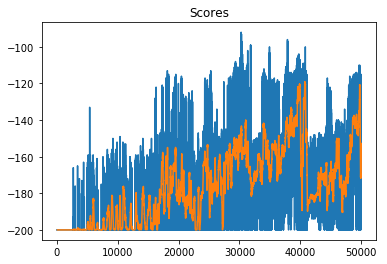

In [39]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

## Testing on greedy policy only

In [ ]:
TEST_RUNS = 100

In [ ]:
# Initialise agent
agent = SARSALearningAgent(env, grid, mode="test")
scores = []
max_avg_score = -np.inf

for i in range(TEST_RUNS):
    
    state = env.reset()
    agent.initialise_map_state(state, Q=trained_Q)
    
    total_reward = 0
    
    while True:
        
        # Take action
        A = agent.action(new_state=False, mode="Test")
        NS, R, done, _ = env.step(A)
        mapped_NS = agent.map_state(NS)
#         NA = agent.action(new_state=True)

        agent.run(A, next_state=mapped_NS, reward=R)
        
        total_reward += R

        if done:
            env.close()
            agent.reset_episode()
            scores.append(total_reward)
            break
            
    if i % 100 == 0:
        if len(scores) > 100:
            avg_score = np.mean(scores[-100:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score
            print("\rEpisode {}/{} | eps {} | Max Average Score {}".format(i, TEST_RUNS, agent.eps, max_avg_score), end="")
            sys.stdout.flush()

In [ ]:
_ = plot_scores(scores)

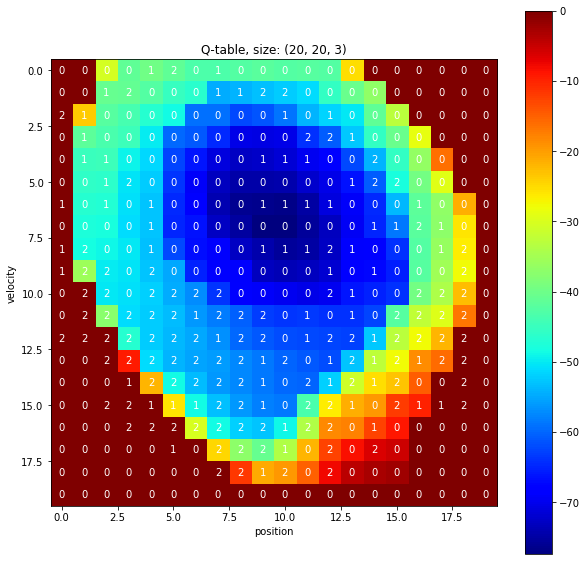

In [40]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(agent.Q_table)

## Modify the grid

In [32]:
RUNS = 50000

In [33]:
low = env.observation_space.low
high = env.observation_space.high

In [34]:
grid = create_uniform_grid(low_bound=low, high_bound=high, bins=(20, 20))

Uniform grid: [low, high] / bins => Splits
	 [-1.2, 0.6] / 20 => [-1.11000004 -1.02000004 -0.93000004 -0.84000003 -0.75000003 -0.66000003
 -0.57000002 -0.48000002 -0.39000002 -0.30000001 -0.21000001 -0.12
 -0.03        0.06        0.15000001  0.24000001  0.33000001  0.42000002
  0.51000002]
	 [-0.07, 0.07] / 20 => [-0.063 -0.056 -0.049 -0.042 -0.035 -0.028 -0.021 -0.014 -0.007  0.
  0.007  0.014  0.021  0.028  0.035  0.042  0.049  0.056  0.063]


In [35]:
# Initialise agent
agent = SARSALearningAgent(env, grid, mode="train")
scores = []
max_avg_score = -np.inf

for i in range(RUNS):
    
    state = env.reset()
    agent.initialise_map_state(state)
    
    total_reward = 0
    
    while True:
        
        # Take action
        A = agent.action(new_state=False)
        NS, R, done, _ = env.step(A)
        mapped_NS = agent.map_state(NS)
        NA = agent.action(new_state=True)

        agent.run(A, mapped_NS, NA, R)
        
        total_reward += R

        if done:
            env.close()
            agent.reset_episode()
            scores.append(total_reward)
            break
            
    if i % 100 == 0:
        if len(scores) > 100:
            avg_score = np.mean(scores[-100:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score
            print("\rEpisode {}/{} | eps {} | Max Average Score {}".format(i, RUNS, agent.eps, max_avg_score), end="")
            sys.stdout.flush()

Environment:  <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size:  (20, 20)
Action space size:  3
Episode 49900/50000 | eps 0.01 | Max Average Score -120.48e Score -181.74

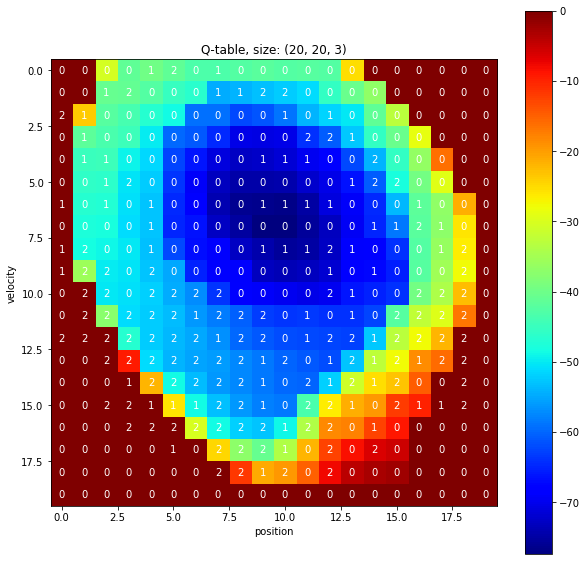

In [41]:
plot_q_table(agent.Q_table)

In [42]:
trained_Q = agent.Q_table

## Running a trained agent

In [43]:
observation = env.reset()
mapped_observation = agent.map_state(observation)
# print(mapped_observation)
for i in range(GLOBAL_STEP):
  
    env.render()
    
    #your agent goes here
    action = epsilon_greedy_policy(trained_Q[mapped_observation[0]][mapped_observation[1]], env, eps=0)
    observation, reward, done, info = env.step(action)
    mapped_observation = agent.map_state(observation)
    
#     print("Observation: %s" % observation)
#     print("Reward: %s" % reward)
#     print("Done: %s" % done)
#     print("Info: %s" % info)
        
    if done: 
      break
            
env.close()
# # show_video()